<a href="https://colab.research.google.com/github/georgezefko/Recommender_System/blob/Matrix_approach/Matrix_factorization20_04_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
#path = '/content/drive/MyDrive/AdvancedBA/Olie_data/archive' #adjust this one to yours
path ='/content/drive/MyDrive/olist_project'
customers = pd.read_csv(path +'/olist_customers_dataset.csv')
reviews = pd.read_csv(path+'/olist_order_reviews_dataset.csv')
geolocation = pd.read_csv(path+'/olist_geolocation_dataset.csv')
items = pd.read_csv(path + '/olist_order_items_dataset.csv')
payments  = pd.read_csv(path + '/olist_order_payments_dataset.csv')
orders= pd.read_csv(path + '/olist_orders_dataset.csv')
products = pd.read_csv(path + '/olist_products_dataset.csv')
sellers =pd.read_csv(path + '/olist_sellers_dataset.csv')
category =  pd.read_csv(path + '/product_category_name_translation.csv')

In [4]:
data = pd.merge(orders,customers,on='customer_id')
data = pd.merge(data,reviews,on='order_id')
data = pd.merge(data,items,on='order_id')
data = pd.merge(data,products,on='product_id')
data = pd.merge(data,sellers,on='seller_id')
data = pd.merge(data, category,on ='product_category_name') # I added this one to get the tra
data.shape

(111686, 36)

We have decided to proceed with the following columns:

 ***Product_id*** : This column specifies the unique id for the products sold\
 ***customer_unique_id*** : This columns provided a uniqie id for all each customer\
 ***reviews_score*** : The score given by each customer to the products they purchased \
 ***order_purchase_timestamp***: When the order for a specific porudct was placed by the customer \
 ***product_category_name_english***: The categories where the products belong to, in english for better understanding \
 ***customer_state***: Where the customers are located in the country \
 ***seller_state***: Where the sellers are located in the country\
 ***Price*** : Price of the product

In [5]:
recommender = data[['review_score','customer_state','seller_state','product_id','product_category_name_english','customer_unique_id','order_purchase_timestamp','order_delivered_customer_date','price']]

In [ ]:
Initially, in order to better understand the product_id and customer_unique_id will convert the string to unique numbers instead.

In [6]:
recommender = recommender.assign(customer_unique_id=(recommender['customer_unique_id']).astype('category').cat.codes)
recommender = recommender.assign(product_id=(recommender['product_id']).astype('category').cat.codes)

In [47]:
recommender.head()

,review_score,customer_state,seller_state,product_id,product_category_name_english,customer_unique_id,order_purchase_timestamp,order_delivered_customer_date,price
0,4,SP,SP,17106,housewares,45758,2017-10-02 10:56:33,2017-10-10 21:25:13,29.99
1,4,SP,SP,17106,housewares,21530,2017-08-15 18:29:31,2017-08-18 14:44:43,29.99
2,5,SP,SP,17106,housewares,87936,2017-08-02 18:24:47,2017-08-07 18:30:01,29.99
3,3,SC,SP,17106,housewares,85228,2017-10-23 23:26:46,2017-11-07 18:04:59,29.99
4,1,SP,SP,23951,housewares,44958,2017-08-24 11:31:28,2017-08-28 20:12:20,46.80


In [48]:
recommender.dtypes

review_score                       int64
customer_state                    object
seller_state                      object
product_id                         int16
product_category_name_english     object
customer_unique_id                 int32
order_purchase_timestamp          object
order_delivered_customer_date     object
price                            float64
dtype: object

In [8]:
recommender.shape

(111686, 9)

In [9]:
ratings_df = recommender[['customer_unique_id','product_id','review_score']]
ratings_df

,customer_unique_id,product_id,review_score
0,45758,17106,4
1,21530,17106,4
2,87936,17106,5
3,85228,17106,3
4,44958,23951,1
...,...,...,...
111681,57240,4599,5
111682,32279,4599,5
111683,40009,22808,5
111684,38842,25855,5


In [10]:
ratings_df.isnull().sum()

customer_unique_id    0
product_id            0
review_score          0
dtype: int64

In [11]:
ratings_df.describe()

,customer_unique_id,product_id,review_score
count,111686.000000,111686.000000,111686.000000
mean,47092.415128,16121.532502,4.018418
std,27143.083445,9281.381481,1.397678
min,0.000000,0.000000,1.000000
25%,23579.250000,8169.000000,4.000000
50%,47156.500000,15947.000000,5.000000
75%,70640.750000,24178.000000,5.000000
max,94087.000000,32327.000000,5.000000


In [12]:
len(ratings_df['customer_unique_id'].unique())

94088

In [14]:

from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(ratings_df, train_size=0.7) # 2/3 -training 


In [15]:
train_df

,customer_unique_id,product_id,review_score
44264,91982,23289,5
103239,75868,13150,5
5287,83433,9207,1
69146,72155,30087,1
72351,52394,20721,5
...,...,...,...
73176,23389,15931,5
2553,56231,21192,5
75586,62350,8581,5
55786,50819,30732,5


In [16]:
print("number of training samples:", train_df.shape[0])
print("number of test samples:", test_df.shape[0])

number of training samples: 78180
number of test samples: 33506


In [17]:
# function to calculate the RMSE
def RMSE(y_true, y_pred):
    return np.linalg.norm(y_true - y_pred) / np.sqrt(len(y_true))

In [18]:
# function to make the boxplot
def MakeBoxplot(y_true, y_pred, title):
    data = [y_pred[y_true == (x*0.5+0.5)] for x in range(10)]
    fig = plt.figure(figsize=(5, 5))
    plt.boxplot(data)
    min_a, max_a = 0., 5.5
    plt.xlim((min_a, max_a))
    plt.ylim((min_a, max_a))
    plt.plot([min_a, max_a * 2], [min_a, max_a], ls='--', color='gray', linewidth=1.0)# x & y values of 2 points of the plot
    plt.xticks(range(12), [x*0.5 for x in range(12)])
    plt.xlabel('True Rating')
    plt.ylabel('Predicted Rating')
    plt.title(title)
    plt.show()

In [19]:
!pip install surprise

     |████████████████████████████████| 11.8MB 331kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617611 sha256=3cd1ee40abf9b191f3f0103b62269c074be1f1667c6a4acd9ba3aa9bddf09310
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


## Model Based Collaborative filtering

In [20]:
from collections import defaultdict 


import surprise

from surprise.reader import Reader
from surprise import Dataset
from surprise.model_selection import GridSearchCV

  
from surprise.model_selection import cross_validate

from surprise import SVD
from surprise import NMF


In [22]:
reader = Reader(rating_scale=(1, 5))
data_surprise = Dataset.load_from_df(train_df, reader)

In [21]:
from surprise.model_selection import GridSearchCV

In [23]:
# find the correct parameters for SVD through parameter tunning in training set
param_grid = {
    #'n_epochs': [20], 
    #'lr_all': [0.005, 0.05],
    'reg_all': [0.01, 0.1],  # regularization strength
    'n_factors': list(range(0,202,5))[1:],# no of factors
    #'biased': [True, False]
}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3) # cross validation 3-folds

gs.fit(data_surprise)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

1.3037541526344618
{'reg_all': 0.01, 'n_factors': 200}


In [24]:
y_true = test_df['review_score'].values 
y_true

array([5, 4, 4, ..., 4, 5, 5])

In [25]:
# We can now use the algorithm that yields the best rmse:
model = gs.best_estimator['rmse']
model.fit(data_surprise.build_full_trainset())

In [26]:
# True values
user_ids_true = test_df['customer_unique_id'].values
product_ids_true = test_df['product_id'].values

RMSE = 1.2643930474886218


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


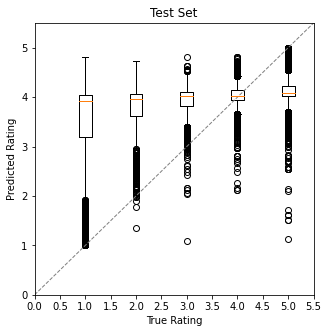

In [27]:
# check the performance
y_pred = []
for user_id, product_id in zip(user_ids_true, product_ids_true):
    r = model.predict(user_id, product_id, verbose=False).est # predict ratings from user_id & product_id in test set
    y_pred.append(r)
y_pred = np.array(y_pred)
# performance
error = RMSE(y_true, y_pred)
print("RMSE =", error) 
MakeBoxplot(y_true, y_pred, 'Test Set')

## Baselines

We will use 4 baseline models:
1. Global mean
2. User's mean
3. Movie's mean
4. Global mean + deviation of user(user mean-global mean) + deviation of the movie(movie mean-global mean)

### Global Mean

In [30]:
y_true = test_df['review_score'].values 
y_true

array([5, 4, 4, ..., 4, 5, 5])

global_mean = 4.0151445382450754
RMSE = 1.3950077964009417


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


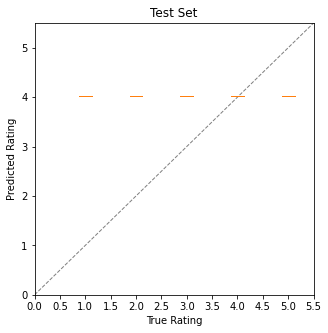

In [32]:
global_mean = train_df['review_score'].mean() 
print("global_mean =", global_mean)
y_pred_1 = []
for i, row in test_df.iterrows():
    y_pred_1.append(global_mean)
y_pred_1 = np.array(y_pred_1)
y_pred_1 = np.clip(y_pred_1, 1.0, 5.0)
# or simply y_pred = np.array([global_mean for i in range(len(y_true))])
# performance
error = RMSE(y_true, y_pred_1)
print("RMSE =", error) # high error
MakeBoxplot(y_true, y_pred_1, 'Test Set')

### User mean

In [36]:
train_df.groupby('customer_unique_id')['review_score'].mean()

customer_unique_id
0        5.0
1        4.0
2        3.0
3        4.0
4        5.0
        ... 
94081    5.0
94083    5.0
94084    4.0
94086    5.0
94087    5.0
Name: review_score, Length: 68545, dtype: float64

In [45]:
test_df.head()

,customer_unique_id,product_id,review_score
53765,75532,20251,5
16517,71109,26873,4
47766,11750,592,4
24739,90490,4920,3
80782,24842,28852,1


In [44]:
test_df[test_df['customer_unique_id']==75532]

,customer_unique_id,product_id,review_score
53765,75532,20251,5


In [50]:
test_df.groupby('customer_unique_id')

In [46]:
user_mean

customer_unique_id
0        5.0
1        4.0
2        3.0
3        4.0
4        5.0
        ... 
94081    5.0
94083    5.0
94084    4.0
94086    5.0
94087    5.0
Name: review_score, Length: 68545, dtype: float64

In [54]:
# No customer like 75532 in train_df
train_df[train_df['customer_unique_id']==75532]

,customer_unique_id,product_id,review_score


In [52]:
test_df

,customer_unique_id,product_id,review_score
53765,75532,20251,5
16517,71109,26873,4
47766,11750,592,4
24739,90490,4920,3
80782,24842,28852,1
...,...,...,...
12053,5119,2904,5
74374,24268,4574,4
56915,7594,1452,4
46709,2573,3910,5


In [39]:
# user mean- use average of all ratings from the user x (here we get different means for different users.)
user_mean = train_df.groupby('customer_unique_id')['review_score'].mean()
y_pred_2 = []
for i, row in test_df.iterrows():
    y_pred_2.append(user_mean[row['customer_unique_id']])
y_pred_2 = np.array(y_pred_2)
y_pred_2 = np.clip(y_pred_2, 1.0, 5.0)
error = RMSE(y_true, y_pred_2)
print("RMSE =", error)
MakeBoxplot(y_true, y_pred_2, 'Test Set')

KeyError: ignored

### movie mean

In [56]:
movie_mean = train_df.groupby('product_id')['review_score'].mean()
# prediction
y_pred_3 = []
for i, row in test_df.iterrows():
    y_pred_3.append(movie_mean[row['product_id']])#use movie mean(average of all ratings from the movie i) as y_pred values
y_pred_3 = np.array(y_pred_3)
y_pred_3 = np.clip(y_pred_3, 1.0, 5.0)
# performance
error = RMSE(y_true, y_pred_3)
print("RMSE =", error)
MakeBoxplot(y_true, y_pred_3, 'Test Set')

KeyError: ignored